In [9]:
# Student Performance Capstone Project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

plt.style.use("default")


In [12]:
# CSV file load
# Make sure the file 'students_performance.csv' is in the same folder as this notebook.

df = pd.read_csv('../data/student-mat.csv')

print("Shape:", df.shape)
df.head()


Shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [13]:
print("Original columns:", df.columns.tolist())

# Rename columns to simpler names (spaces hata rahe hain)
df = df.rename(columns={
    "gender": "gender",
    "race/ethnicity": "race_ethnicity",
    "parental level of education": "parent_education",
    "lunch": "lunch",
    "test preparation course": "test_prep",
    "math score": "math_score",
    "reading score": "reading_score",
    "writing score": "writing_score"
})

print("Renamed columns:", df.columns.tolist())

print("\nInfo:")
print(df.info())

print("\nMissing values:")
print(df.isna().sum())

print("\nSummary stats (numeric):")
df.describe()


Original columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']
Renamed columns: ['gender', 'race_ethnicity', 'parent_education', 'lunch', 'test_prep', 'math_score', 'reading_score', 'writing_score']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            1000 non-null   object
 1   race_ethnicity    1000 non-null   object
 2   parent_education  1000 non-null   object
 3   lunch             1000 non-null   object
 4   test_prep         1000 non-null   object
 5   math_score        1000 non-null   int64 
 6   reading_score     1000 non-null   int64 
 7   writing_score     1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Missing values:
gender              0
race_ethnicity      0
parent_educat

,math_score,reading_score,writing_score
count,1000.000000,1000.000000,1000.000000
mean,66.396000,69.002000,67.738000
std,15.402871,14.737272,15.600985
min,13.000000,27.000000,23.000000
25%,56.000000,60.000000,58.000000
50%,66.500000,70.000000,68.000000
75%,77.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000


In [14]:
# Average score
df["avg_score"] = df[["math_score", "reading_score", "writing_score"]].mean(axis=1)

# Pass if average >= 60
df["pass_overall"] = (df["avg_score"] >= 60).astype(int)

# Pass if math >= 60
df["pass_math"] = (df["math_score"] >= 60).astype(int)

df.head()


,gender,race_ethnicity,parent_education,lunch,test_prep,math_score,reading_score,writing_score,avg_score,pass_overall,pass_math
0,male,group A,high school,standard,completed,67,67,63,65.666667,1,1
1,female,group D,some high school,free/reduced,none,40,59,55,51.333333,0,0
2,male,group E,some college,free/reduced,none,59,60,50,56.333333,0,0
3,male,group B,high school,standard,none,77,78,68,74.333333,1,1
4,male,group E,associate's degree,standard,completed,78,73,68,73.000000,1,1


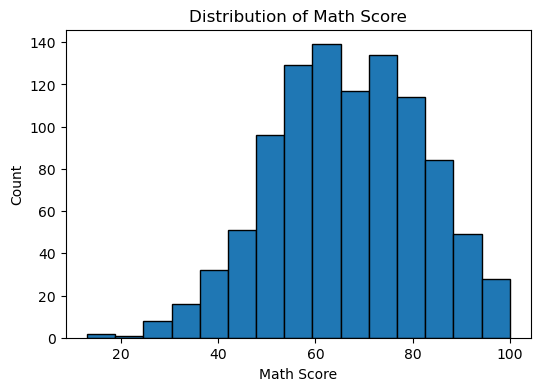

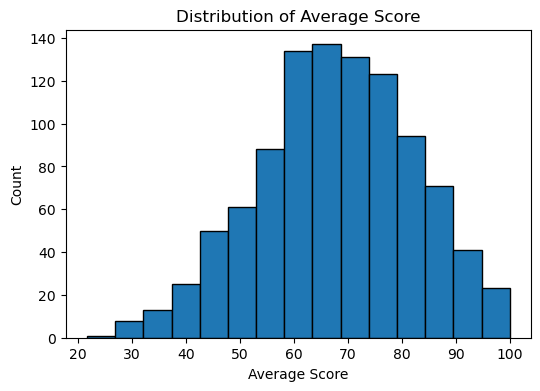

Average scores by gender:


,math_score,reading_score,writing_score,avg_score
gender,,,,
female,63.196687,71.888199,71.708075,68.930987
male,69.384913,66.305609,64.029014,66.573179


In [15]:
# Distribution of scores
plt.figure(figsize=(6,4))
plt.hist(df["math_score"], bins=15, edgecolor="black")
plt.xlabel("Math Score")
plt.ylabel("Count")
plt.title("Distribution of Math Score")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["avg_score"], bins=15, edgecolor="black")
plt.xlabel("Average Score")
plt.ylabel("Count")
plt.title("Distribution of Average Score")
plt.show()

# Average score by gender
group_gender = df.groupby("gender")[["math_score", "reading_score", "writing_score", "avg_score"]].mean()
print("Average scores by gender:")
display(group_gender)


Correlation matrix:


,math_score,reading_score,writing_score,avg_score
math_score,1.000000,0.819398,0.805944,0.919834
reading_score,0.819398,1.000000,0.954274,0.970219
writing_score,0.805944,0.954274,1.000000,0.966367
avg_score,0.919834,0.970219,0.966367,1.000000


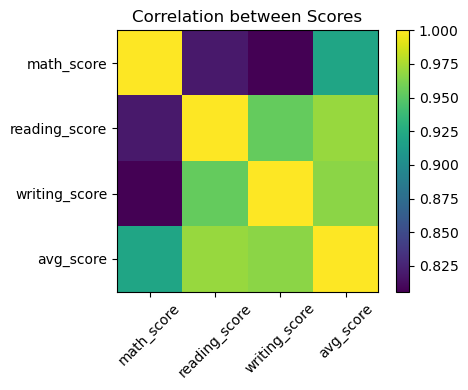

In [16]:
numeric_cols = ["math_score", "reading_score", "writing_score", "avg_score"]

corr = df[numeric_cols].corr()
print("Correlation matrix:")
display(corr)

plt.figure(figsize=(5,4))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation between Scores")
plt.tight_layout()
plt.show()


In [17]:
# Features (X) and targets (y)
# For regression, we will try to predict math_score
# For classification, we will predict pass_overall

# Select features: use all except direct target columns
feature_cols = [
    "gender",
    "race_ethnicity",
    "parent_education",
    "lunch",
    "test_prep",
    "reading_score",
    "writing_score"
]

X = df[feature_cols]
y_reg = df["math_score"]
y_clf = df["pass_overall"]

# One-hot encode categorical features
cat_cols = ["gender", "race_ethnicity", "parent_education", "lunch", "test_prep"]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Shape before encoding:", X.shape)
print("Shape after encoding:", X_encoded.shape)
print("Encoded columns:", X_encoded.columns.tolist()[:10], "...")

# Train-test split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X_encoded, y_reg, y_clf, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


Shape before encoding: (1000, 7)
Shape after encoding: (1000, 14)
Encoded columns: ['reading_score', 'writing_score', 'gender_male', 'race_ethnicity_group B', 'race_ethnicity_group C', 'race_ethnicity_group D', 'race_ethnicity_group E', "parent_education_bachelor's degree", 'parent_education_high school', "parent_education_master's degree"] ...
X_train: (800, 14) X_test: (200, 14)


In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3]


array([[-1.0287678 , -1.08126488, -1.04605967, -0.50780078, -0.68993823,
        -0.60816364, -0.3822719 , -0.36708551, -0.49609064, -0.27958383,
        -0.52527808,  2.0317985 , -1.34059793,  0.69982706],
       [ 1.23395569,  1.44782008, -1.04605967, -0.50780078, -0.68993823,
         1.64429429, -0.3822719 ,  2.7241609 , -0.49609064, -0.27958383,
        -0.52527808, -0.49217479, -1.34059793,  0.69982706],
       [-0.4116614 , -0.36793323,  0.95596841,  1.96927621, -0.68993823,
        -0.60816364, -0.3822719 , -0.36708551, -0.49609064, -0.27958383,
        -0.52527808,  2.0317985 ,  0.74593581, -1.42892445]])

In [19]:
# 1) Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_reg_train)

y_reg_pred_lin = lin_reg.predict(X_test_scaled)

print("=== Linear Regression Performance (Math Score) ===")
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred_lin))
print("MSE:", mean_squared_error(y_reg_test, y_reg_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_lin)))
print("R^2:", r2_score(y_reg_test, y_reg_pred_lin))

# 2) Random Forest Regressor (no scaling needed)
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    n_jobs=-1
)
rf_reg.fit(X_train, y_reg_train)

y_reg_pred_rf = rf_reg.predict(X_test)

print("\n=== Random Forest Regressor Performance (Math Score) ===")
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred_rf))
print("MSE:", mean_squared_error(y_reg_test, y_reg_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_rf)))
print("R^2:", r2_score(y_reg_test, y_reg_pred_rf))


=== Linear Regression Performance (Math Score) ===
MAE: 4.561765032371565
MSE: 30.281717975930686
RMSE: 5.502882696908111
R^2: 0.87062289224987

=== Random Forest Regressor Performance (Math Score) ===
MAE: 4.8797404166666665
MSE: 35.7151882021875
RMSE: 5.976218553750147
R^2: 0.8474086656502331


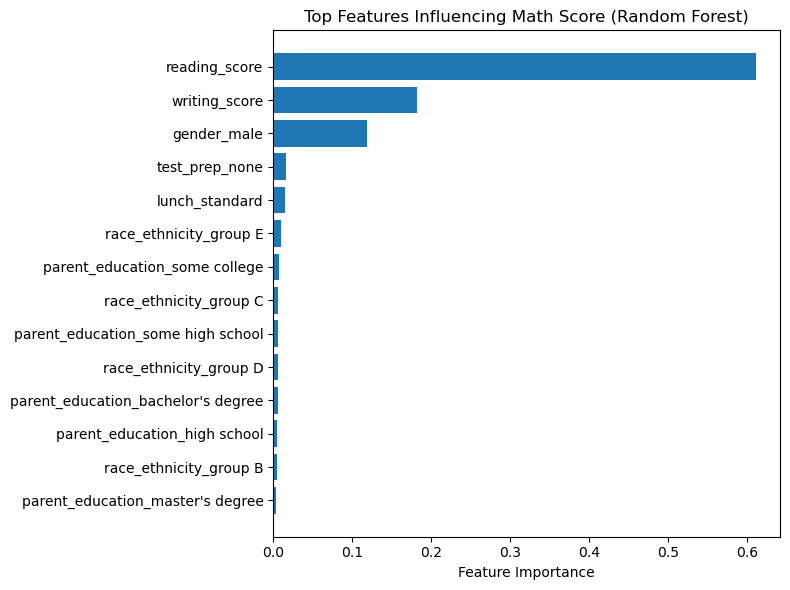

In [20]:
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

top_n = min(15, len(feature_names))

plt.figure(figsize=(8,6))
plt.barh(range(top_n), importances[indices][:top_n][::-1])
plt.yticks(range(top_n), feature_names[indices][:top_n][::-1])
plt.xlabel("Feature Importance")
plt.title("Top Features Influencing Math Score (Random Forest)")
plt.tight_layout()
plt.show()


In [21]:
# 1) Logistic Regression (classification)
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_scaled, y_clf_train)

y_clf_pred_log = log_clf.predict(X_test_scaled)

print("=== Logistic Regression (Pass Overall) ===")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_pred_log))
print("\nClassification Report:\n", classification_report(y_clf_test, y_clf_pred_log))

# 2) Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    n_jobs=-1
)
rf_clf.fit(X_train, y_clf_train)

y_clf_pred_rf = rf_clf.predict(X_test)

print("\n=== Random Forest Classifier (Pass Overall) ===")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_pred_rf))
print("\nClassification Report:\n", classification_report(y_clf_test, y_clf_pred_rf))


=== Logistic Regression (Pass Overall) ===
Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        57
           1       0.98      0.99      0.99       143

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.98      0.98       200


=== Random Forest Classifier (Pass Overall) ===
Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93        57
           1       0.96      0.99      0.97       143

    accuracy                           0.96       200
   macro avg       0.96      0.94      0.95       200
weighted avg       0.96      0.96      0.96       200



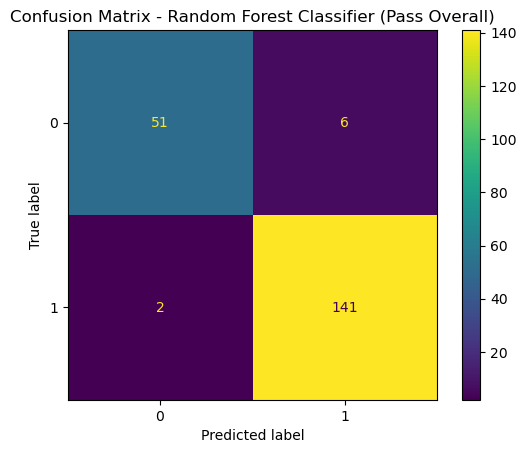

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_clf_test, y_clf_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix - Random Forest Classifier (Pass Overall)")
plt.show()


In [23]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(rf_reg, "models/rf_reg_math.pkl")
joblib.dump(rf_clf, "models/rf_clf_pass.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(X_train.columns.tolist(), "models/feature_columns.pkl")

print("Models and scaler saved in 'models/' folder.")


Models and scaler saved in 'models/' folder.
